### Import Necessary Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Collection

In [2]:
path = r"/kaggle/input/adni-extracted-axial/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [3]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [4]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [5]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")
    
print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [6]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

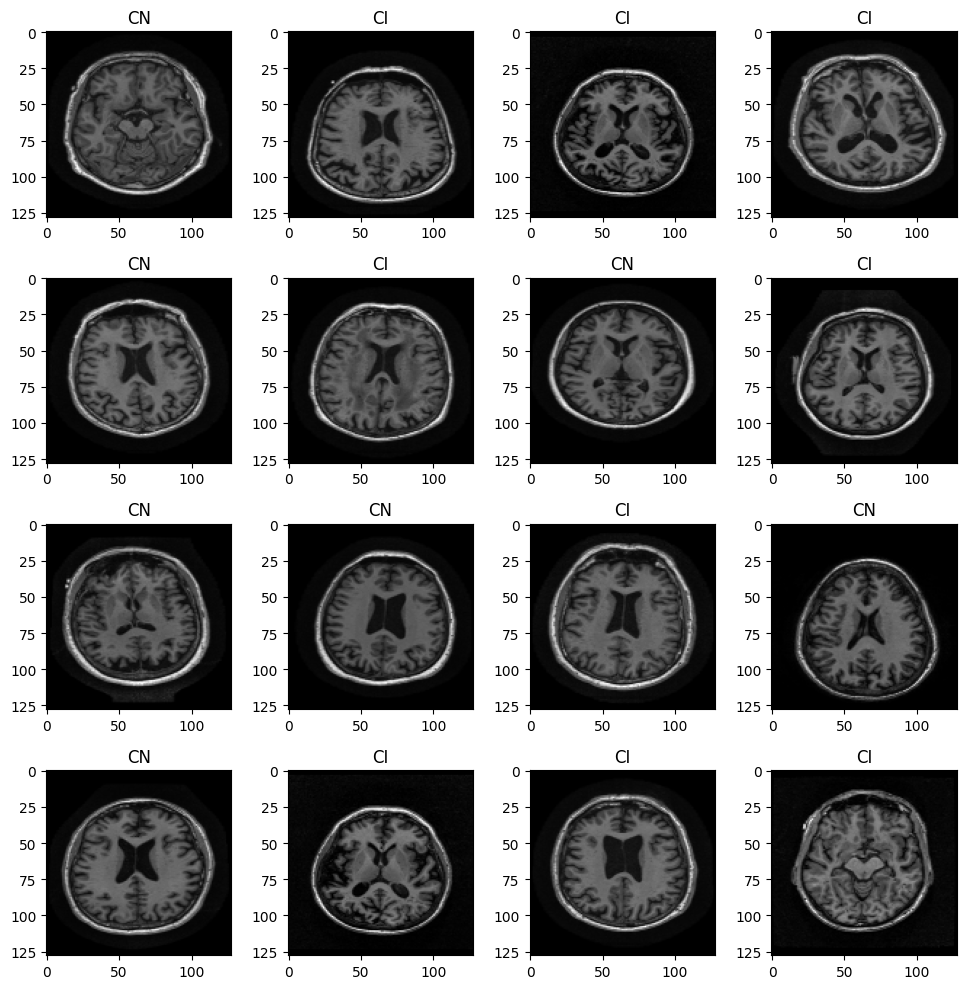

In [7]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.savefig("image_sample.png")
plt.show()

CN


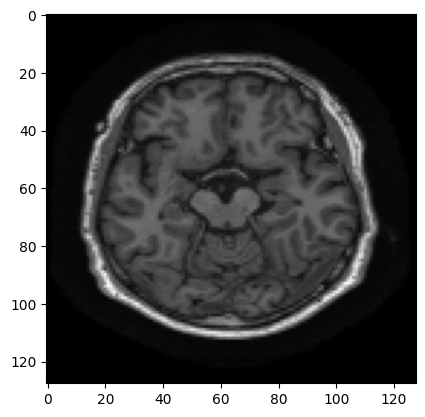

CI


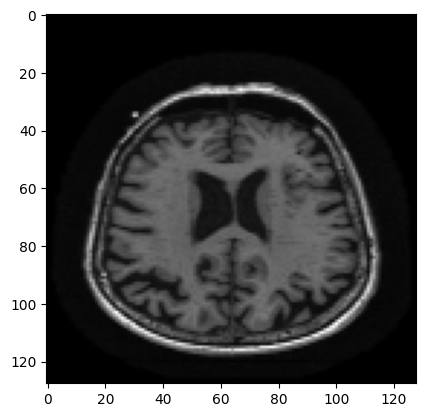

AD


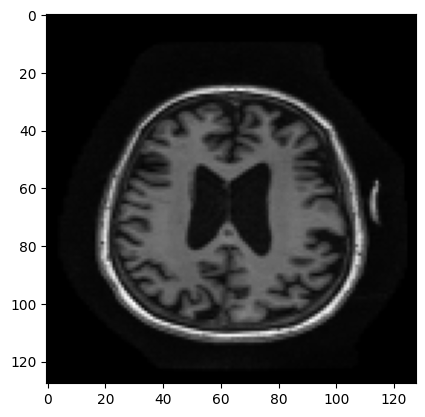

In [8]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [9]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


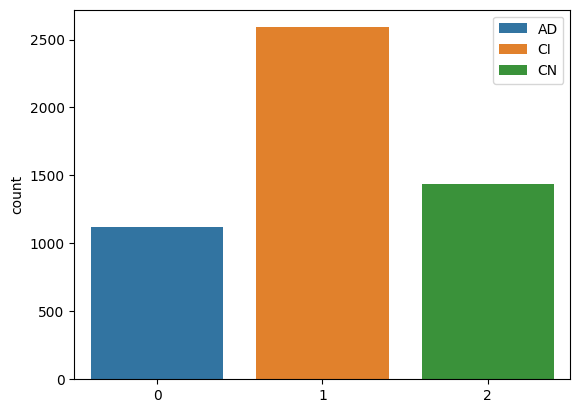

In [10]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.savefig("class_data_length.png")
plt.show()

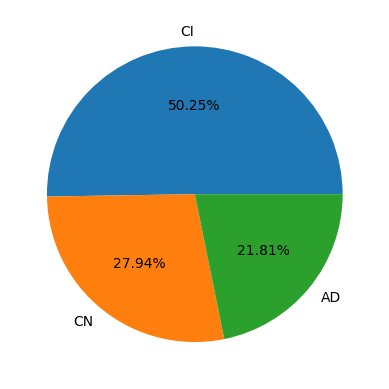

In [11]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [13]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [14]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [15]:
print(pd.Series(y).value_counts())

2    3002
1    3002
0    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [16]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [17]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15, 
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


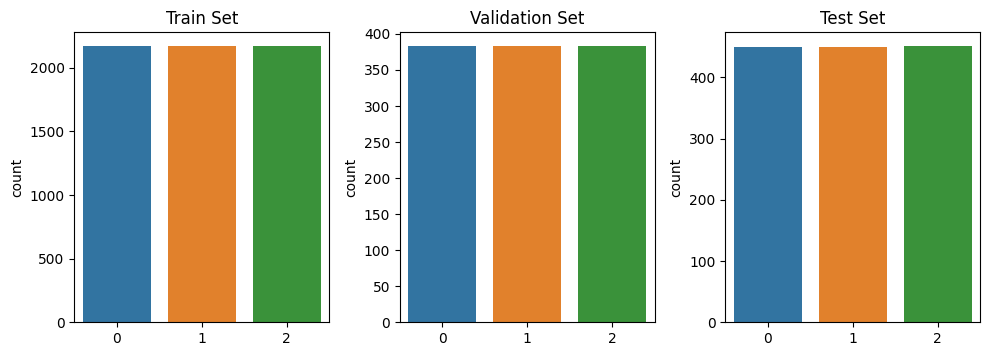

In [18]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

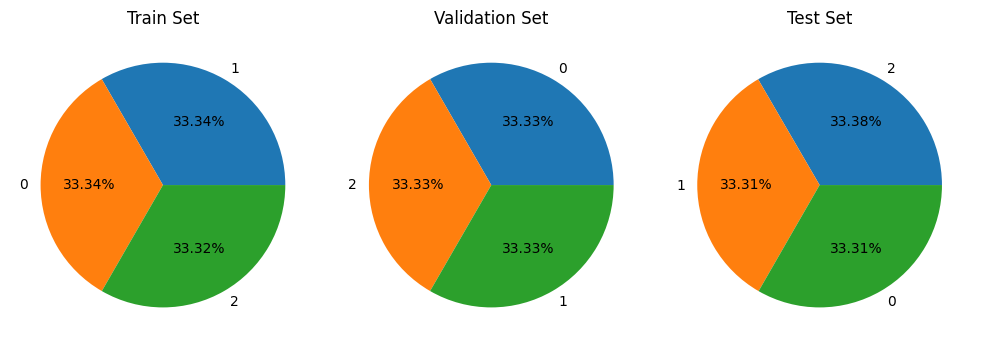

In [19]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.savefig("balance_data.png")
plt.show()

### Model Building and Training

In [20]:
# Model building

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 100, activation = "relu"),
    tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 3, activation = "softmax")
])

In [21]:

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=200, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.25),  # Dropout layer after the first convolutional layer

    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.25),  # Dropout layer after the second convolutional layer

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # Dropout layer after the first dense layer

    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # Dropout layer after the second dense layer

    tf.keras.layers.Dense(units=3, activation="softmax")
])


In [22]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 126, 126, 64)      256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 126, 126, 64)     

In [24]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

Layer 0: conv2d_4 (None, 128, 128, 64) 640
Layer 1: batch_normalization (None, 128, 128, 64) 256
Layer 2: activation (None, 128, 128, 64) 0
Layer 3: conv2d_5 (None, 126, 126, 64) 36928
Layer 4: batch_normalization_1 (None, 126, 126, 64) 256
Layer 5: activation_1 (None, 126, 126, 64) 0
Layer 6: max_pooling2d_4 (None, 63, 63, 64) 0
Layer 7: dropout_4 (None, 63, 63, 64) 0
Layer 8: conv2d_6 (None, 63, 63, 128) 73856
Layer 9: batch_normalization_2 (None, 63, 63, 128) 512
Layer 10: activation_2 (None, 63, 63, 128) 0
Layer 11: conv2d_7 (None, 61, 61, 128) 147584
Layer 12: batch_normalization_3 (None, 61, 61, 128) 512
Layer 13: activation_3 (None, 61, 61, 128) 0
Layer 14: max_pooling2d_5 (None, 30, 30, 128) 0
Layer 15: dropout_5 (None, 30, 30, 128) 0
Layer 16: flatten_2 (None, 115200) 0
Layer 17: dense_6 (None, 512) 58982912
Layer 18: batch_normalization_4 (None, 512) 2048
Layer 19: activation_4 (None, 512) 0
Layer 20: dropout_6 (None, 512) 0
Layer 21: dense_7 (None, 256) 131328
Layer 22: batc

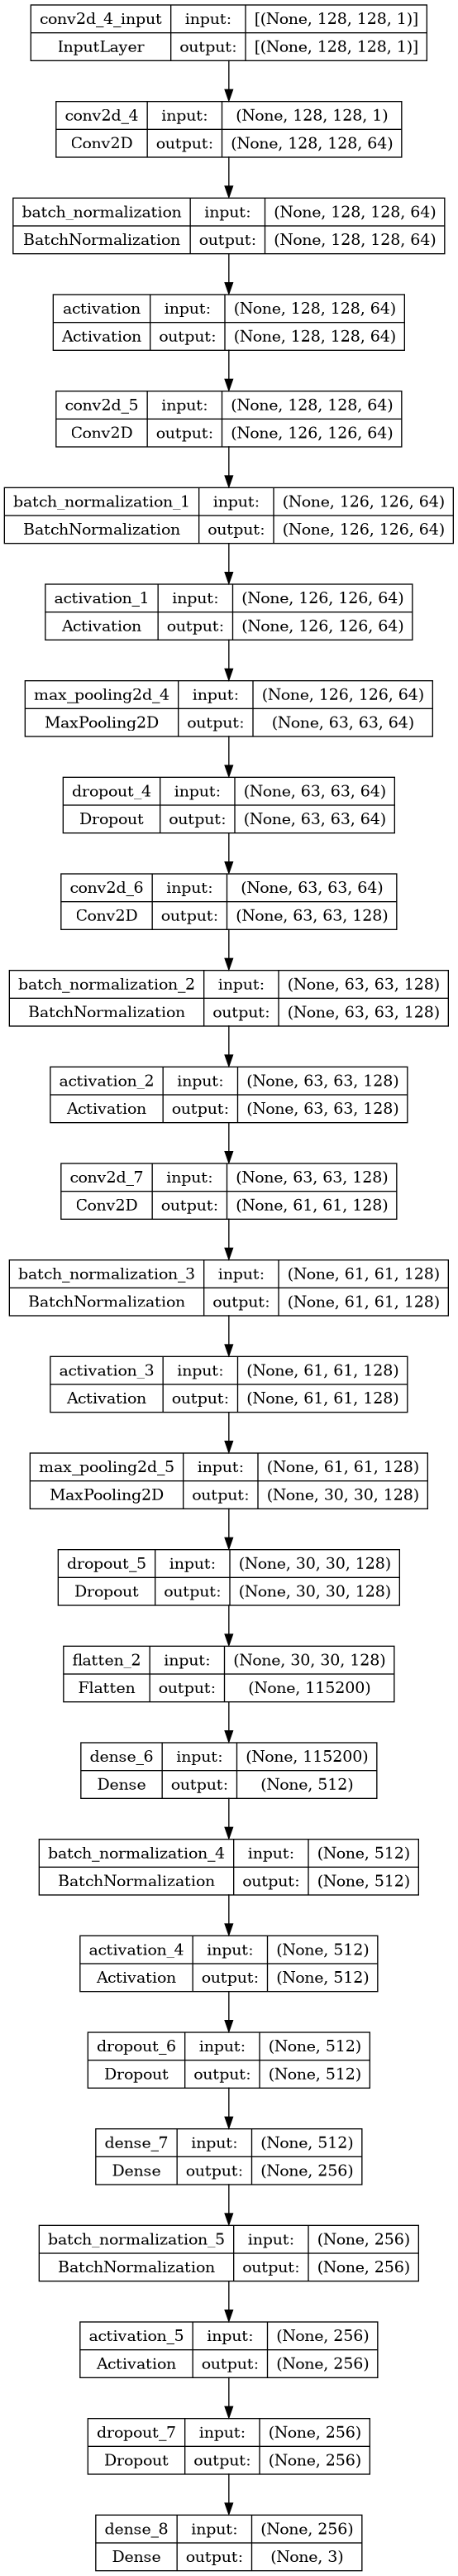

In [25]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True, to_file='model_architecture.png')
model_arch

In [26]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [27]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.h5", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val)) #callbacks = [cb1, cb2],

Epoch 1/100


2024-06-27 02:59:44.041843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


204/204 [==============================] - 24s 82ms/step - loss: 0.8178 - accuracy: 0.6680 - val_loss: 9.9998 - val_accuracy: 0.3333
Epoch 2/100
204/204 [==============================] - 16s 76ms/step - loss: 0.3109 - accuracy: 0.8835 - val_loss: 8.5484 - val_accuracy: 0.3333
Epoch 3/100
204/204 [==============================] - 16s 76ms/step - loss: 0.1722 - accuracy: 0.9377 - val_loss: 5.6979 - val_accuracy: 0.3429
Epoch 4/100
204/204 [==============================] - 16s 76ms/step - loss: 0.1014 - accuracy: 0.9659 - val_loss: 0.0690 - val_accuracy: 0.9756
Epoch 5/100
204/204 [==============================] - 15s 76ms/step - loss: 0.0771 - accuracy: 0.9748 - val_loss: 0.0554 - val_accuracy: 0.9826
Epoch 6/100
204/204 [==============================] - 15s 76ms/step - loss: 0.0628 - accuracy: 0.9791 - val_loss: 0.0641 - val_accuracy: 0.9774
Epoch 7/100
204/204 [==============================] - 16s 76ms/step - loss: 0.0582 - accuracy: 0.9800 - val_loss: 0.0774 - val_accuracy: 0.97

In [28]:
result_df = pd.DataFrame(history.history)
result_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.817765,0.667999,9.999756,0.333333
1,0.310872,0.883492,8.548396,0.333333
2,0.172212,0.937750,5.697910,0.342907
3,0.101446,0.965878,0.068994,0.975631
4,0.077116,0.974792,0.055395,0.982594


In [29]:
result_df.describe()

,loss,accuracy,val_loss,val_accuracy
count,100.000000,100.000000,100.000000,100.000000
mean,0.030109,0.989228,0.308933,0.964030
std,0.087628,0.035152,1.409364,0.111507
min,0.001974,0.667999,0.020870,0.333333
25%,0.007961,0.992622,0.044152,0.981723
50%,0.012029,0.995927,0.059034,0.986075
75%,0.022462,0.997387,0.079387,0.989556
max,0.817765,0.999539,9.999756,0.993037


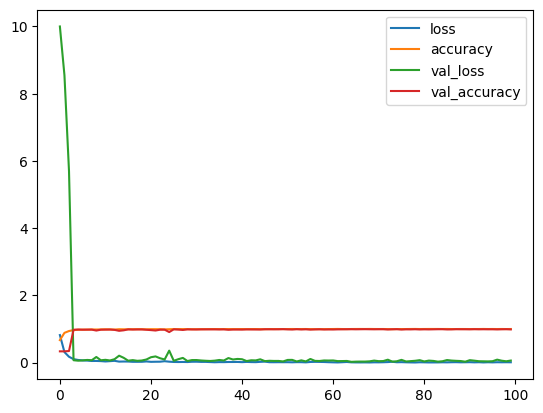

In [30]:
# Learning curves

result_df.plot()
plt.savefig("model_learnign_curve.png")
plt.show()

In [31]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 [==============================] - 3s 16ms/step - loss: 4.9094e-04 - accuracy: 0.9998


In [32]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 3s 14ms/step
tf.Tensor(
[[2169    0    0]
 [   0 2168    1]
 [   0    0 2168]], shape=(3, 3), dtype=int32)


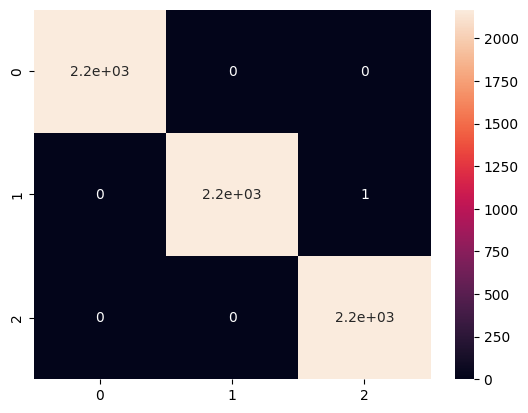

In [33]:
sns.heatmap(cm, annot = True)
plt.savefig("confusion_matrix_train.png")
plt.show()

In [34]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2169
True Negatives : 4337
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


Class CI : 

True Positives : 2168
True Negatives : 4337
False Positives : 0
False Negatives : 1

Precision : 1.0
Recall (Sensitivity) : 0.9995389580451821
F1-Score : 0.9997694258704174


Class CN : 

True Positives : 2168
True Negatives : 4337
False Positives : 1
False Negatives : 0

Precision : 0.9995389580451821
Recall (Sensitivity) : 1.0
F1-Score : 0.9997694258704174


In [35]:
# Classification Report
# Define the list of label names
label_names = ['AD', 'CI', 'CN']
clf_report = metrics.classification_report(y_train, y_train_pred_labels, target_names=label_names)
print(clf_report)

              precision    recall  f1-score   support

          AD       1.00      1.00      1.00      2169
          CI       1.00      1.00      1.00      2169
          CN       1.00      1.00      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506



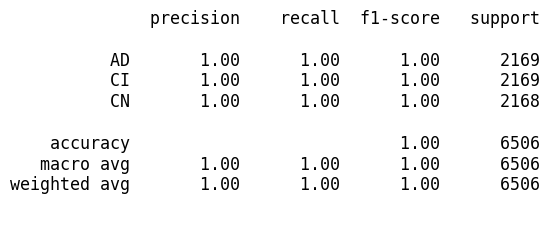

In [36]:
# Function to save the classification report as an image
def save_classification_report_as_image(report, filename):
    # Split the classification report into lines
    lines = report.split('\n')
    
    # Create a figure and axis to plot the text
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')
    
    # Add the report text to the plot
    plt.text(0, 1, report, fontsize=12, fontname='monospace', verticalalignment='top')
    
    # Save the plot as an image file
    plt.savefig(filename, bbox_inches='tight')

# Save the classification report as an image
save_classification_report_as_image(clf_report, 'classification_report_train.png')

### Model Validation

In [37]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 [==============================] - 1s 19ms/step - loss: 0.0641 - accuracy: 0.9904


43/43 [==============================] - 1s 14ms/step


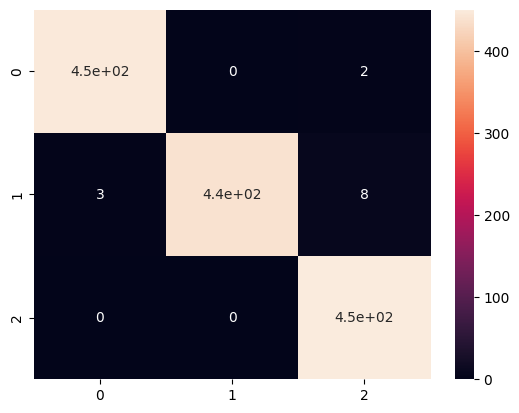

In [38]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.savefig("test_confusion_matrix.png")
plt.show()

In [39]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 448
True Negatives : 898
False Positives : 3
False Negatives : 2

Precision : 0.9933481152993349
Recall (Sensitivity) : 0.9955555555555555
F1-Score : 0.9944506104328523


Class CI : 

True Positives : 439
True Negatives : 901
False Positives : 0
False Negatives : 11

Precision : 1.0
Recall (Sensitivity) : 0.9755555555555555
F1-Score : 0.9876265466816647


Class CN : 

True Positives : 451
True Negatives : 890
False Positives : 10
False Negatives : 0

Precision : 0.9783080260303688
Recall (Sensitivity) : 1.0
F1-Score : 0.9890350877192984


In [40]:
# Classification Report
label_names = ['AD', 'CI', 'CN']
clf_report_test = metrics.classification_report(y_test, y_test_pred_labels, target_names=label_names)
print(clf_report_test)

              precision    recall  f1-score   support

          AD       0.99      1.00      0.99       450
          CI       1.00      0.98      0.99       450
          CN       0.98      1.00      0.99       451

    accuracy                           0.99      1351
   macro avg       0.99      0.99      0.99      1351
weighted avg       0.99      0.99      0.99      1351



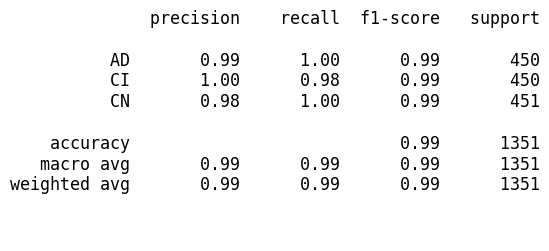

In [41]:
# Save the classification report as an image
save_classification_report_as_image(clf_report_test, 'classification_report.png')

### Saving the Model

In [42]:
model.save("clf_model_final.h5")